Testing mlflow and pytorch

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

/home/studio-lab-user/.conda/envs/PRUEBA/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#train and test data directory
train_dir = "data_split/train"
test_dir = "data_split/test"
val_dir = "data_split/val"


#load the train, val and test data
train_data = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((288,288)),transforms.ToTensor()
]))

val_data = ImageFolder(val_dir,transform = transforms.Compose([
    transforms.Resize((288,288)),transforms.ToTensor()
]))

test_data = ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((288,288)),transforms.ToTensor()
]))

In [3]:
img, label = train_data[0]
print(img.shape,label)


torch.Size([3, 288, 288]) 0


In [4]:
print("Follwing classes are there : \n",train_data.classes)

Follwing classes are there : 
 ['gamma', 'proton']


Label : gamma


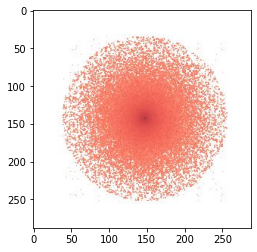

In [5]:
import matplotlib.pyplot as plt
def display_img(img,label):
    print(f"Label : {train_data.classes[label]}")
    plt.imshow(img.permute(1,2,0)) #permute method reshapes the image from (3,150,150) to (150,150,3)

#display the first image in the dataset
display_img(*train_data[0])

The data is divided into batches using the PyTorch DataLoader class. We create two objects train_dl and val_dl for training and validation data respectively by giving parameters training data and batch size into the DataLoader Class.

In [6]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")


#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 2009
Length of Validation Data : 267


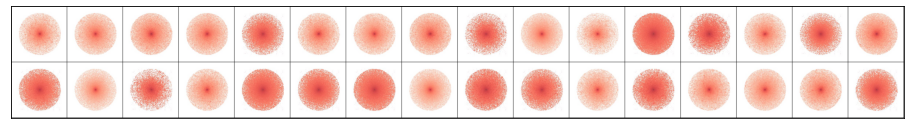

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [8]:

import os

import mlflow

mlflow.set_tracking_uri("https://dagshub.com/andreasorroche/TFM.mlflow")

os.environ["MLFLOW_TRACKING_USERNAME"] = "andreasorroche"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "repomlflow"


In [10]:
import os

import pytorch_lightning as pl
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

try:
    from torchmetrics.functional import accuracy
except ImportError:
    from pytorch_lightning.metrics.functional import accuracy

import mlflow.pytorch
from mlflow.tracking import MlflowClient

class Model(pl.LightningModule):
    def __init__(self, num_classes=3):
        super(Model, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
    
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 288/2/2 is 72.
        # This means that our feature tensors are now 72 x 72, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=72 * 72 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 72 * 72 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)

    def training_step(self, batch, batch_nb):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        pred = logits.argmax(dim=1)
        acc = accuracy(pred, y)

        # Use the current of PyTorch logger
        self.log("train_loss", loss, on_epoch=True)
        self.log("acc", acc, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

def print_auto_logged_info(r):

    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(r.data.params))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))


model = Model()

# Initialize a trainer
trainer = pl.Trainer(max_epochs=3, progress_bar_refresh_rate=20)

# Auto log all MLflow entities
mlflow.pytorch.autolog()

# Train the model
with mlflow.start_run() as run:
    trainer.fit(model, train_dl)

# fetch the auto logged parameters and metrics
print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))

/home/studio-lab-user/.conda/envs/PRUEBA/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 336   
1 | conv2 | Conv2d    | 2.6 K 
2 | pool  | MaxPool2d | 0     
3 | drop  | Dropout2d | 0     
4 | fc    | Linear    | 373 K 
------------------------------------
376 K     Trainable params
0         Non-trainable params
376 K     Total params


Epoch 2: 100%|██████████| 63/63 [00:43<00:00,  1.43it/s, loss=0.65, v_num=1] 


2022/07/24 14:20:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/studio-lab-user/.conda/envs/PRUEBA/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


run_id: 2f0e99ba119c40959176273e080c5520
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {'epochs': '3', 'optimizer_name': 'Adam', 'lr': '0.02', 'betas': '(0.9, 0.999)', 'eps': '1e-08', 'weight_decay': '0', 'amsgrad': 'False', 'maximize': 'False', 'foreach': 'None', 'capturable': 'False'}
metrics: {'train_loss': 0.616146326065063, 'train_loss_step': 0.608412027359009, 'acc': 0.722249865531921, 'acc_step': 0.759999990463257, 'train_loss_epoch': 0.616146326065063, 'acc_epoch': 0.722249865531921}
tags: {'Mode': 'training'}


In [13]:
correct = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_data:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what w
        correct += (predicted == labels).sum().item()

In [14]:
correct

294

In [25]:
#Counting elements in each folder
import os

count = 0
dir_path = 'data_split/test/gamma'
for path in os.scandir(dir_path):
    if path.is_file():
        count += 1
print('file count gamma:', count)

count = 0
dir_path = 'data_split/test/proton'
for path in os.scandir(dir_path):
    if path.is_file():
        count += 1
print('file count proton:', count)

file count gamma: 110
file count proton: 294
